# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os

from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, NMF, SVDpp

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# CONFIGURATION

In [3]:
class Config:
    """Configuration for experiments"""
    DATASET = 'ml-1m'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    RESULTS_DIR = 'results/centralized'
    FIGURES_DIR = 'figures'

    # SVD hyperparameters (will be tuned)
    SVD_PARAMS = {
        'n_factors': 100,
        'n_epochs': 20,
        'lr_all': 0.005,
        'reg_all': 0.02
    }

    def __init__(self):
        # Create directories
        os.makedirs(self.RESULTS_DIR, exist_ok=True)
        os.makedirs(self.FIGURES_DIR, exist_ok=True)

config = Config()

# DATA LOADING

In [4]:
def load_movielens_1m():
    """
    Load MovieLens-1M dataset
    Returns: surprise Dataset object
    """
    print("="*60)
    print("LOADING MOVIELENS-1M DATASET")
    print("="*60)

    # Load the built-in MovieLens-1M dataset
    data = Dataset.load_builtin('ml-1m')

    # Get basic statistics
    raw_ratings = data.raw_ratings
    n_users = len(set([rating[0] for rating in raw_ratings]))
    n_items = len(set([rating[1] for rating in raw_ratings]))
    n_ratings = len(raw_ratings)

    print(f"✓ Dataset loaded successfully")
    print(f"  - Users: {n_users:,}")
    print(f"  - Movies: {n_items:,}")
    print(f"  - Ratings: {n_ratings:,}")
    print(f"  - Sparsity: {(1 - n_ratings/(n_users*n_items))*100:.2f}%")
    print()

    return data

# BASELINE MODELS

In [5]:
def train_svd_baseline(trainset, testset, params=None):
    """
    Train SVD model as centralized baseline

    Args:
        trainset: Surprise trainset
        testset: Surprise testset
        params: Dictionary of SVD parameters

    Returns:
        model: Trained SVD model
        results: Dictionary containing metrics
    """
    print("="*60)
    print("TRAINING SVD BASELINE")
    print("="*60)

    if params is None:
        params = config.SVD_PARAMS

    print(f"Parameters: {params}")
    print()

    # Initialize and train model
    start_time = datetime.now()
    algo = SVD(**params, verbose=True)
    algo.fit(trainset)
    training_time = (datetime.now() - start_time).total_seconds()

    print(f"\n✓ Training completed in {training_time:.2f} seconds")

    # Predictions on test set
    print("\nEvaluating on test set...")
    predictions = algo.test(testset)

    # Calculate metrics
    rmse = accuracy.rmse(predictions, verbose=True)
    mae = accuracy.mae(predictions, verbose=True)

    # Calculate additional metrics
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])

    # R² score
    ss_res = np.sum((actual - predicted)**2)
    ss_tot = np.sum((actual - np.mean(actual))**2)
    r2 = 1 - (ss_res / ss_tot)

    # MSE
    mse = np.mean((actual - predicted)**2)

    results = {
        'model_name': 'SVD',
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'training_time': training_time,
        'n_predictions': len(predictions),
        'params': params
    }

    print(f"\n{'='*60}")
    print("RESULTS SUMMARY")
    print(f"{'='*60}")
    print(f"RMSE:          {rmse:.4f}")
    print(f"MAE:           {mae:.4f}")
    print(f"MSE:           {mse:.4f}")
    print(f"R²:            {r2:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    print(f"{'='*60}\n")

    return algo, results, predictions

# HYPERPARAMETER TUNING

In [6]:
def hyperparameter_tuning(data, cv=3):
    """
    Perform grid search for optimal hyperparameters

    Args:
        data: Surprise Dataset
        cv: Number of cross-validation folds

    Returns:
        best_params: Dictionary of best parameters
        cv_results: Cross-validation results
    """
    print("="*60)
    print("HYPERPARAMETER TUNING (This may take a while...)")
    print("="*60)

    param_grid = {
        'n_factors': [50, 100, 150],
        'n_epochs': [20, 30],
        'lr_all': [0.002, 0.005, 0.01],
        'reg_all': [0.02, 0.05, 0.1]
    }

    print(f"Parameter grid: {param_grid}")
    print(f"Cross-validation folds: {cv}")
    print(f"Total combinations: {len(param_grid['n_factors']) * len(param_grid['n_epochs']) * len(param_grid['lr_all']) * len(param_grid['reg_all'])}")
    print("\nStarting grid search...\n")

    gs = GridSearchCV(
        SVD,
        param_grid,
        measures=['rmse', 'mae'],
        cv=cv,
        n_jobs=-1,  # Use all CPU cores
        joblib_verbose=2
    )

    gs.fit(data)

    # Best parameters
    best_params = gs.best_params['rmse']
    best_rmse = gs.best_score['rmse']
    best_mae = gs.best_score['mae']

    print(f"\n{'='*60}")
    print("GRID SEARCH RESULTS")
    print(f"{'='*60}")
    print(f"Best RMSE:   {best_rmse:.4f}")
    print(f"Best MAE:    {best_mae:.4f}")
    print(f"Best params: {best_params}")
    print(f"{'='*60}\n")

    # Get detailed results
    cv_results = pd.DataFrame.from_dict(gs.cv_results)

    return best_params, cv_results, gs

# CROSS-VALIDATION

In [7]:
def perform_cross_validation(data, algo_class=SVD, params=None, cv=5):
    """
    Perform k-fold cross-validation

    Args:
        data: Surprise Dataset
        algo_class: Algorithm class (SVD, SVDpp, etc.)
        params: Algorithm parameters
        cv: Number of folds

    Returns:
        cv_results: Cross-validation results
    """
    print("="*60)
    print(f"CROSS-VALIDATION ({cv}-Fold)")
    print("="*60)

    if params is None:
        params = config.SVD_PARAMS

    algo = algo_class(**params)

    cv_results = cross_validate(
        algo,
        data,
        measures=['RMSE', 'MAE'],
        cv=cv,
        verbose=True
    )

    # Calculate statistics
    mean_rmse = np.mean(cv_results['test_rmse'])
    std_rmse = np.std(cv_results['test_rmse'])
    mean_mae = np.mean(cv_results['test_mae'])
    std_mae = np.std(cv_results['test_mae'])

    print(f"\n{'='*60}")
    print("CROSS-VALIDATION RESULTS")
    print(f"{'='*60}")
    print(f"RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
    print(f"MAE:  {mean_mae:.4f} ± {std_mae:.4f}")
    print(f"{'='*60}\n")

    return {
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'mean_mae': mean_mae,
        'std_mae': std_mae,
        'cv_results': cv_results
    }

# COMPARISON WITH OTHER CF METHODS

In [8]:
def compare_cf_methods(trainset, testset):
    """
    Compare SVD with other CF methods

    Args:
        trainset: Surprise trainset
        testset: Surprise testset

    Returns:
        comparison_results: DataFrame with comparison
    """
    print("="*60)
    print("COMPARING COLLABORATIVE FILTERING METHODS")
    print("="*60)

    methods = {
        'SVD': SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02),
        'SVD++': SVDpp(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02),
        'NMF': NMF(n_factors=100, n_epochs=50),
        'KNN-Basic': KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': True})
    }

    results = []

    for name, algo in methods.items():
        print(f"\nTraining {name}...")
        start_time = datetime.now()

        algo.fit(trainset)
        predictions = algo.test(testset)

        training_time = (datetime.now() - start_time).total_seconds()
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)

        results.append({
            'Method': name,
            'RMSE': rmse,
            'MAE': mae,
            'Training Time (s)': training_time
        })

        print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Time: {training_time:.2f}s")

    comparison_df = pd.DataFrame(results)
    comparison_df = comparison_df.sort_values('RMSE')

    print(f"\n{'='*60}")
    print("COMPARISON RESULTS (sorted by RMSE)")
    print(f"{'='*60}")
    print(comparison_df.to_string(index=False))
    print(f"{'='*60}\n")

    return comparison_df

# VISUALIZATION

In [9]:
def plot_prediction_analysis(predictions, save_path=None):
    """
    Create visualizations for prediction analysis

    Args:
        predictions: List of Surprise Prediction objects
        save_path: Path to save figure
    """
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    errors = actual - predicted

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Actual vs Predicted scatter plot
    axes[0, 0].scatter(actual, predicted, alpha=0.3, s=10)
    axes[0, 0].plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect prediction')
    axes[0, 0].set_xlabel('Actual Rating', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Rating', fontsize=12)
    axes[0, 0].set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Error distribution
    axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Error Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Error by actual rating
    rating_bins = [1, 2, 3, 4, 5]
    error_by_rating = []
    for i in range(len(rating_bins)):
        mask = (actual >= rating_bins[i]) & (actual < rating_bins[i] + 1)
        error_by_rating.append(errors[mask])

    axes[1, 0].boxplot(error_by_rating, labels=rating_bins)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1, 0].set_xlabel('Actual Rating', fontsize=12)
    axes[1, 0].set_ylabel('Prediction Error', fontsize=12)
    axes[1, 0].set_title('Error by Actual Rating', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Rating distribution
    axes[1, 1].hist(actual, bins=10, alpha=0.5, label='Actual', edgecolor='black')
    axes[1, 1].hist(predicted, bins=10, alpha=0.5, label='Predicted', edgecolor='black')
    axes[1, 1].set_xlabel('Rating', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Rating Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to {save_path}")

    plt.show()

def plot_comparison_bar(comparison_df, save_path=None):
    """
    Create bar plot comparing different methods

    Args:
        comparison_df: DataFrame with comparison results
        save_path: Path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # RMSE comparison
    axes[0].bar(comparison_df['Method'], comparison_df['RMSE'],
                color='steelblue', edgecolor='black')
    axes[0].set_ylabel('RMSE', fontsize=12)
    axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(comparison_df['RMSE']):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

    # MAE comparison
    axes[1].bar(comparison_df['Method'], comparison_df['MAE'],
                color='coral', edgecolor='black')
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(comparison_df['MAE']):
        axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to {save_path}")

    plt.show()

# SAVE RESULTS

In [10]:
def save_results(results, filename='svd_baseline_results.json'):
    """
    Save results to JSON file

    Args:
        results: Dictionary of results
        filename: Output filename
    """
    filepath = os.path.join(config.RESULTS_DIR, filename)

    # Convert numpy types to Python types
    def convert_to_serializable(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj

    serializable_results = {
        k: convert_to_serializable(v) for k, v in results.items()
    }

    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=4)

    print(f"✓ Results saved to {filepath}")

# MAIN EXECUTION

In [11]:
def main():
    """Main execution function"""

    print("\n" + "="*60)
    print("CENTRALIZED BASELINE: SVD ON MOVIELENS-1M")
    print("="*60 + "\n")

    # 1. Load data
    data = load_movielens_1m()

    # 2. Train-test split
    print("Splitting data into train and test sets...")
    trainset, testset = train_test_split(
        data,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_STATE
    )
    print(f"✓ Train size: {trainset.n_ratings:,} ratings")
    print(f"✓ Test size:  {len(testset):,} ratings\n")

    # 3. Train SVD baseline with default parameters
    svd_model, svd_results, predictions = train_svd_baseline(trainset, testset)

    # 4. Hyperparameter tuning (optional - comment out if too slow)
    print("\nDo you want to perform hyperparameter tuning? (This may take 10-30 minutes)")
    tune = input("Enter 'yes' to tune, or press Enter to skip: ").strip().lower()

    if tune == 'yes':
        best_params, cv_results_df, gs = hyperparameter_tuning(data, cv=3)

        # Retrain with best parameters
        print("\nRetraining with best parameters...")
        svd_model_tuned, svd_results_tuned, predictions_tuned = train_svd_baseline(
            trainset, testset, params=best_params
        )

        # Use tuned results
        svd_results = svd_results_tuned
        predictions = predictions_tuned

    # 5. Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv_results = perform_cross_validation(data, SVD, svd_results['params'], cv=5)

    # 6. Compare with other CF methods
    comparison_df = compare_cf_methods(trainset, testset)

    # 7. Visualizations
    print("\nGenerating visualizations...")

    plot_prediction_analysis(
        predictions,
        save_path=os.path.join(config.FIGURES_DIR, 'svd_prediction_analysis.png')
    )

    plot_comparison_bar(
        comparison_df,
        save_path=os.path.join(config.FIGURES_DIR, 'cf_methods_comparison.png')
    )

    # 8. Save results
    final_results = {
        'dataset': config.DATASET,
        'test_size': config.TEST_SIZE,
        'timestamp': datetime.now().isoformat(),
        'svd_results': svd_results,
        'cv_results': {
            'mean_rmse': cv_results['mean_rmse'],
            'std_rmse': cv_results['std_rmse'],
            'mean_mae': cv_results['mean_mae'],
            'std_mae': cv_results['std_mae']
        },
        'comparison': comparison_df.to_dict('records')
    }

    save_results(final_results)

    # 9. Final summary
    print("\n" + "="*60)
    print("FINAL SUMMARY - CENTRALIZED BASELINE")
    print("="*60)
    print(f"Model:         SVD")
    print(f"Test RMSE:     {svd_results['rmse']:.4f}")
    print(f"Test MAE:      {svd_results['mae']:.4f}")
    print(f"CV RMSE:       {cv_results['mean_rmse']:.4f} ± {cv_results['std_rmse']:.4f}")
    print(f"CV MAE:        {cv_results['mean_mae']:.4f} ± {cv_results['std_mae']:.4f}")
    print(f"Training Time: {svd_results['training_time']:.2f}s")
    print("="*60)

    print("\n✓ All done! Results saved to:", config.RESULTS_DIR)
    print("✓ Figures saved to:", config.FIGURES_DIR)

    return svd_model, svd_results, comparison_df


CENTRALIZED BASELINE: SVD ON MOVIELENS-1M

LOADING MOVIELENS-1M DATASET
✓ Dataset loaded successfully
  - Users: 6,040
  - Movies: 3,706
  - Ratings: 1,000,209
  - Sparsity: 95.53%

Splitting data into train and test sets...
✓ Train size: 800,167 ratings
✓ Test size:  200,042 ratings

TRAINING SVD BASELINE
Parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✓ Training completed in 5.08 seconds

Evaluating on test set...
RMSE: 0.8729
MAE:  0.6845

RESULTS SUMMARY
RMSE:          0.8729
MAE:           0.6845
MSE:           0.7619
R²:            0.3888
Training Time: 5.08s




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  2.4min finished



GRID SEARCH RESULTS
Best RMSE:   0.8642
Best MAE:    0.6809
Best params: {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}


Retraining with best parameters...
TRAINING SVD BASELINE
Parameters: {'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

✓ Training completed in 5.00 seconds

Evaluating on test set...
RMSE: 0.8546
MAE:  0.6731

RESULTS SUMMARY
RMSE:          0.8546
MAE:           0.6731
MSE:           0.7303
R²:            0.4141
Training Time: 5.00s


Performing 5-fold cross-validation...
CROSS-VALIDATION (5-Fold)
Evaluating RMSE, MAE of algorithm SVD on 5 sp

/var/folders/2q/f289hqz52f5fb6b5mmkxr8g00000gp/T/ipykernel_96298/3863897416.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(error_by_rating, labels=rating_bins)


✓ Figure saved to figures/svd_prediction_analysis.png


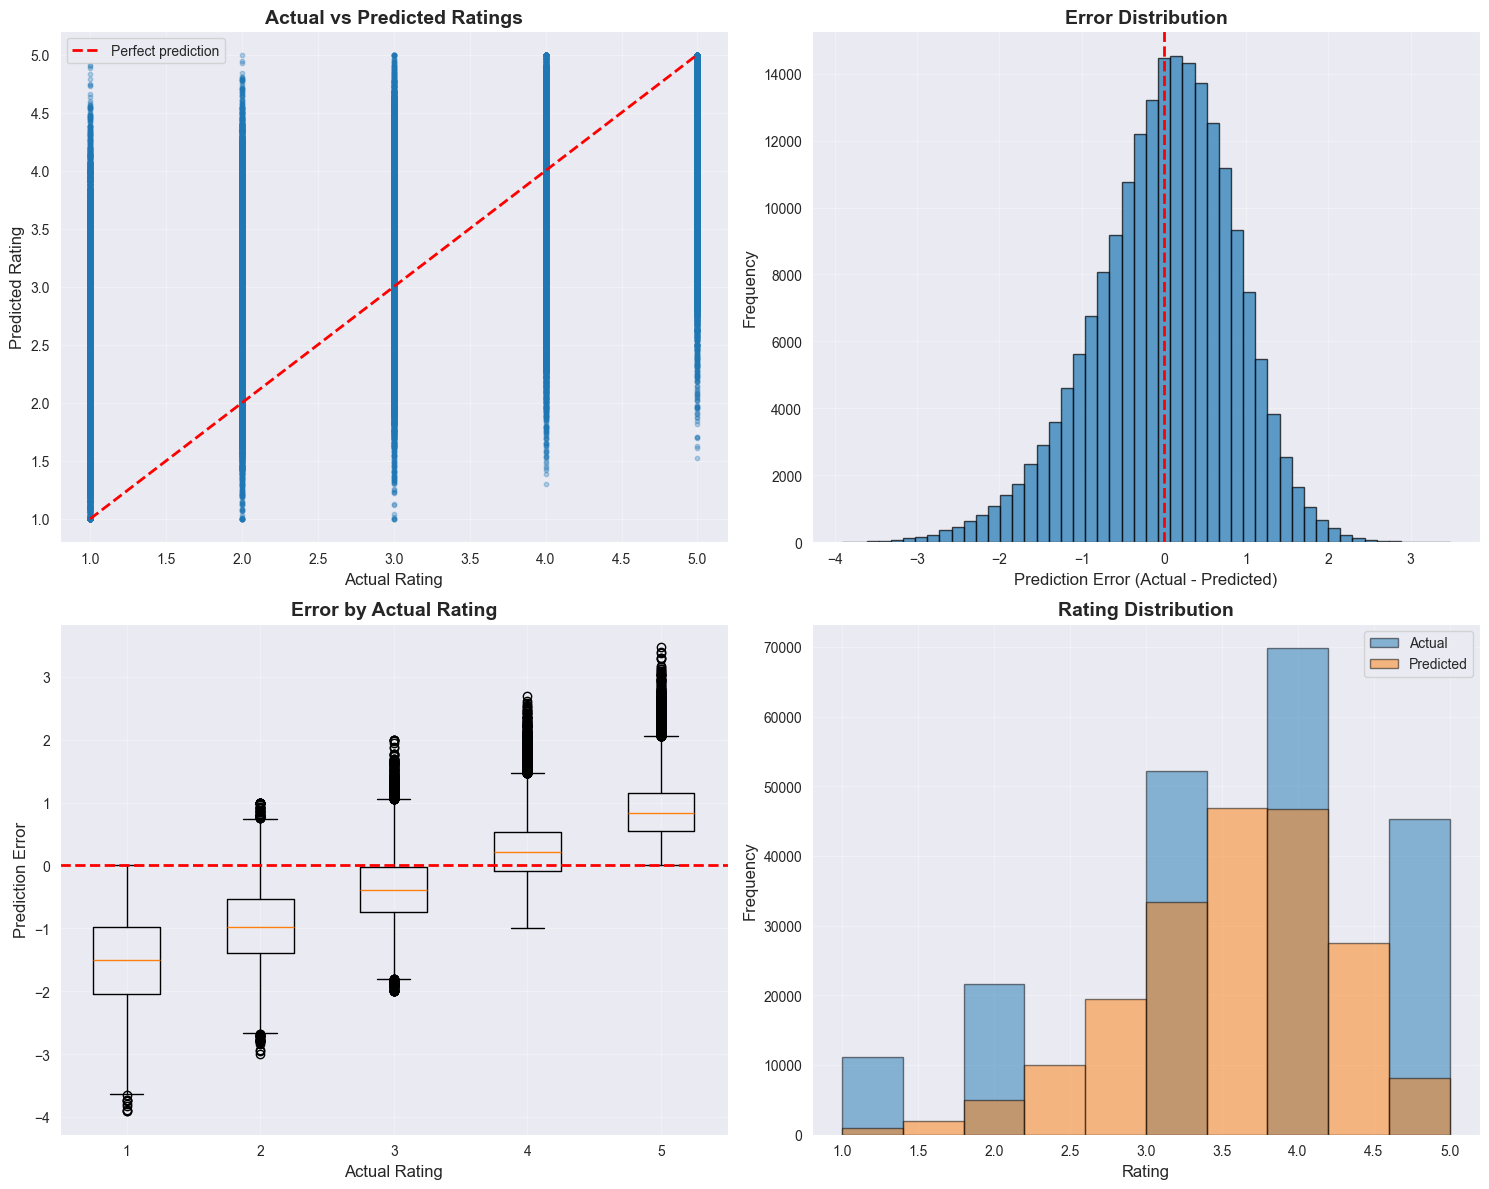

✓ Figure saved to figures/cf_methods_comparison.png


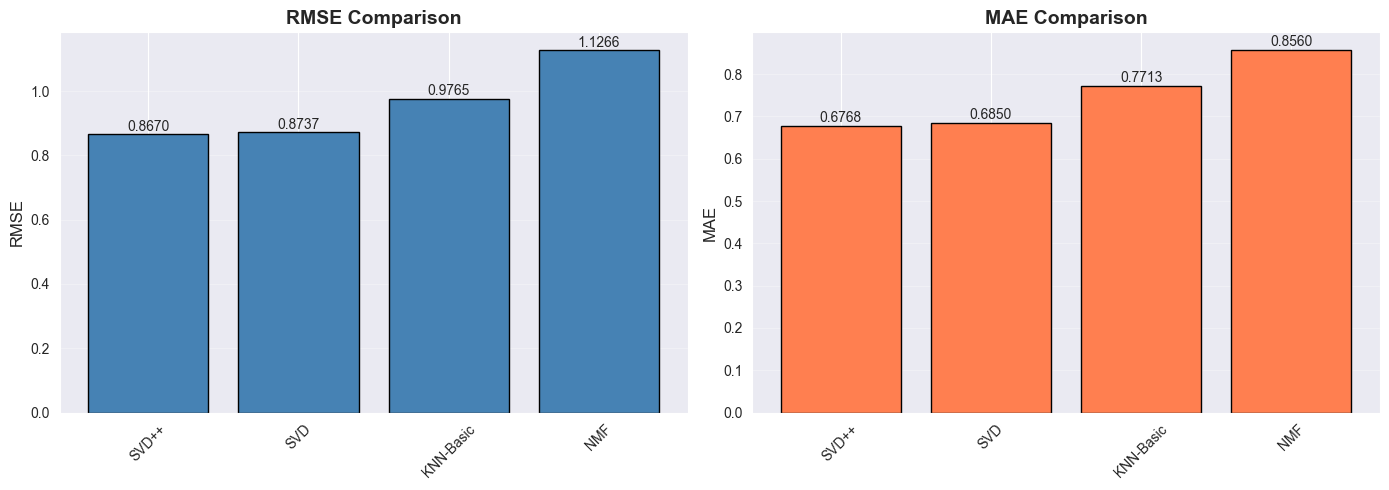

✓ Results saved to results/centralized/svd_baseline_results.json

FINAL SUMMARY - CENTRALIZED BASELINE
Model:         SVD
Test RMSE:     0.8546
Test MAE:      0.6731
CV RMSE:       0.8546 ± 0.0027
CV MAE:        0.6734 ± 0.0024
Training Time: 5.00s

✓ All done! Results saved to: results/centralized
✓ Figures saved to: figures


In [12]:
if __name__ == "__main__":
    model, results, comparison = main()